In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter
from lifelines.utils import concordance_index
from lifelines.plotting import add_at_risk_counts
from lifelines import LogNormalAFTFitter

In [71]:
data = pd.read_csv('telco.csv')
print("Shape:", data.shape)
print("Columns:", data.columns.tolist())

Shape: (1000, 15)
Columns: ['ID', 'region', 'tenure', 'age', 'marital', 'address', 'income', 'ed', 'retire', 'gender', 'voice', 'internet', 'forward', 'custcat', 'churn']


In [13]:
data.head()


,ID,region,tenure,age,marital,address,income,ed,retire,gender,voice,internet,forward,custcat,churn
0,1,Zone 2,13,44,Married,9,64,College degree,No,Male,No,No,Yes,Basic service,Yes
1,2,Zone 3,11,33,Married,7,136,Post-undergraduate degree,No,Male,Yes,No,Yes,Total service,Yes
2,3,Zone 3,68,52,Married,24,116,Did not complete high school,No,Female,No,No,No,Plus service,No
3,4,Zone 2,33,33,Unmarried,12,33,High school degree,No,Female,No,No,No,Basic service,Yes
4,5,Zone 2,23,30,Married,9,30,Did not complete high school,No,Male,No,No,Yes,Plus service,No


In [17]:
data_encoded = pd.get_dummies(data, columns=['region', 'marital', 'ed', 'retire', 'gender', 'voice', 'internet', 'forward', 'custcat'], drop_first=True)
data_encoded['churn_event'] = (data_encoded['churn'] == 'Yes').astype(int)
data_encoded.drop('churn', axis=1, inplace=True)

In [89]:
cat_vars = ['region', 'marital', 'ed', 'retire', 'gender', 'voice', 'internet', 'forward', 'custcat']
data_encoded = pd.get_dummies(data, columns=cat_vars, drop_first=True)

data_encoded['event'] = (data_encoded['churn'] == 'Yes').astype(int)
data_encoded.drop('churn', axis=1, inplace=True)

## Exploratory Analysis

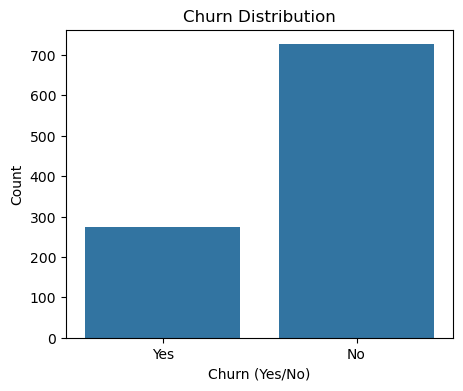

In [23]:
plt.figure(figsize=(5,4))
sns.countplot(data=data, x='churn')
plt.title("Churn Distribution")
plt.xlabel("Churn (Yes/No)")
plt.ylabel("Count")
plt.show()

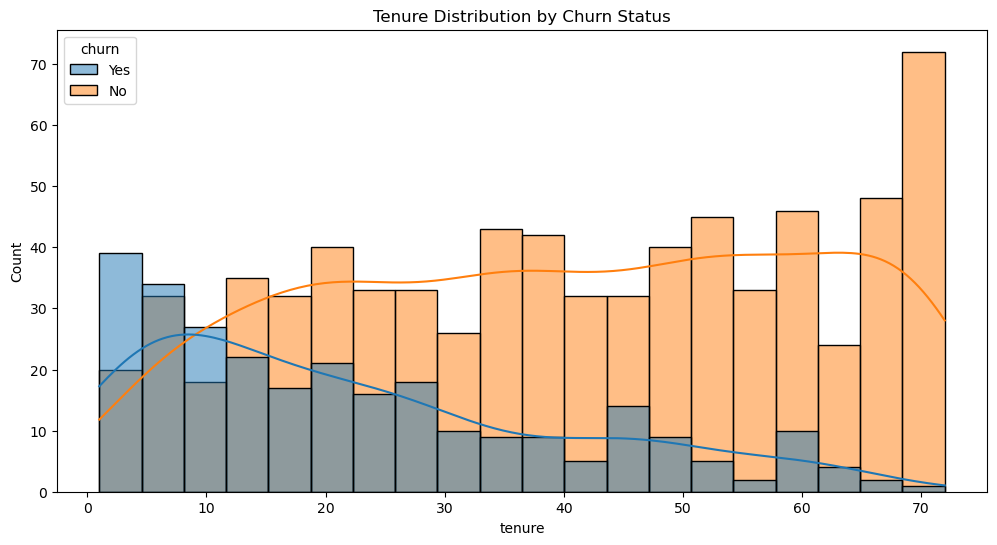

In [25]:
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='tenure', hue='churn', kde=True, bins=20)
plt.title('Tenure Distribution by Churn Status')
plt.show()

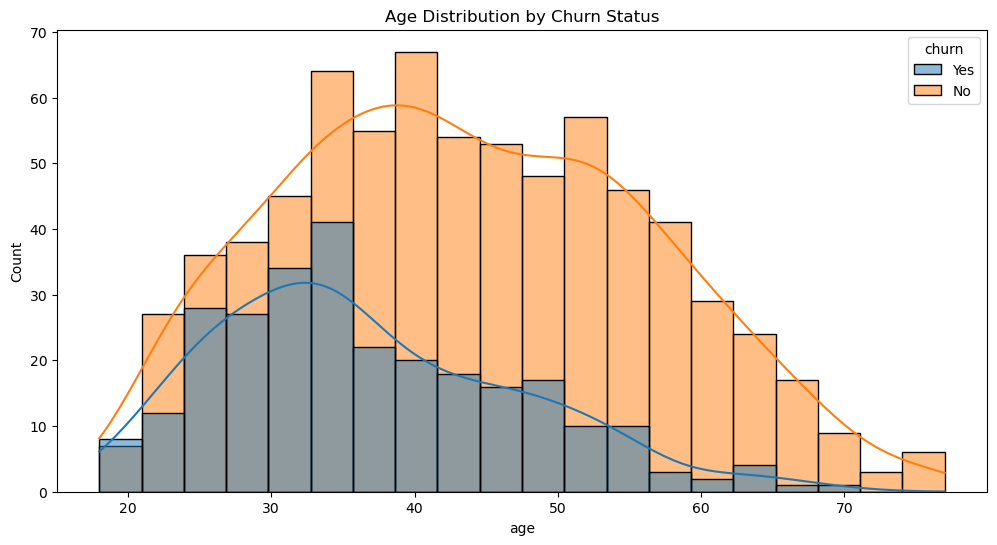

In [27]:
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='age', hue='churn', kde=True, bins=20)
plt.title('Age Distribution by Churn Status')
plt.show()numerical_cols = ['tenure', 'age', 'address', 'income']
plt.figure(figsize=(10, 8))
sns.heatmap(data[numerical_cols + ['ID']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

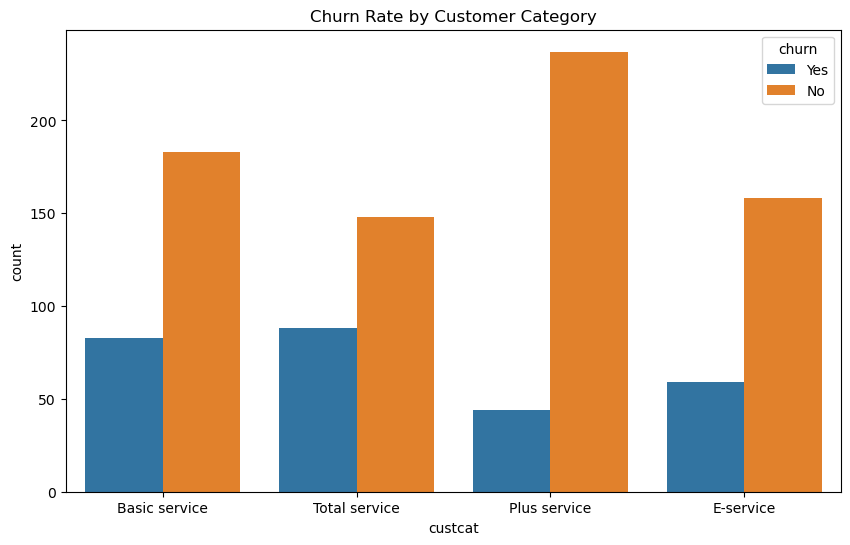

In [31]:
plt.figure(figsize=(10, 6))
sns.countplot(x='custcat', hue='churn', data=data)
plt.title('Churn Rate by Customer Category')
plt.show()

## Parametric Survival Models (AFT)

In [34]:
survival_data = data_encoded.copy()

weibull_aft = WeibullAFTFitter()
weibull_aft.fit(survival_data, duration_col='tenure', event_col='churn_event')


<lifelines.WeibullAFTFitter: fitted with 1000 total observations, 726 right-censored observations>

In [36]:
lognormal_aft = LogNormalAFTFitter()
lognormal_aft.fit(survival_data, duration_col='tenure', event_col='churn_event')

<lifelines.LogNormalAFTFitter: fitted with 1000 total observations, 726 right-censored observations>

In [38]:
loglogistic_aft = LogLogisticAFTFitter()
loglogistic_aft.fit(survival_data, duration_col='tenure', event_col='churn_event')

<lifelines.LogLogisticAFTFitter: fitted with 1000 total observations, 726 right-censored observations>

In [40]:
weibull_aic = weibull_aft.AIC_
lognormal_aic = lognormal_aft.AIC_
loglogistic_aic = loglogistic_aft.AIC_

In [42]:
weibull_ci = concordance_index(survival_data['tenure'], -weibull_aft.predict_median(survival_data), survival_data['churn_event'])
lognormal_ci = concordance_index(survival_data['tenure'], -lognormal_aft.predict_median(survival_data), survival_data['churn_event'])
loglogistic_ci = concordance_index(survival_data['tenure'], -loglogistic_aft.predict_median(survival_data), survival_data['churn_event'])

In [44]:
comparison_df = pd.DataFrame({
    'Model': ['Weibull AFT', 'LogNormal AFT', 'LogLogistic AFT'],
    'AIC': [weibull_aic, lognormal_aic, loglogistic_aic],
    'Concordance Index': [weibull_ci, lognormal_ci, loglogistic_ci]
}).sort_values('AIC')
print(comparison_df)

             Model          AIC  Concordance Index
1    LogNormal AFT  2950.300213           0.210604
2  LogLogistic AFT  2952.258260           0.210212
0      Weibull AFT  2958.357127           0.215151


In [46]:
timeline = np.linspace(0, 80, 100)
sample_data = survival_data.iloc[[0]]

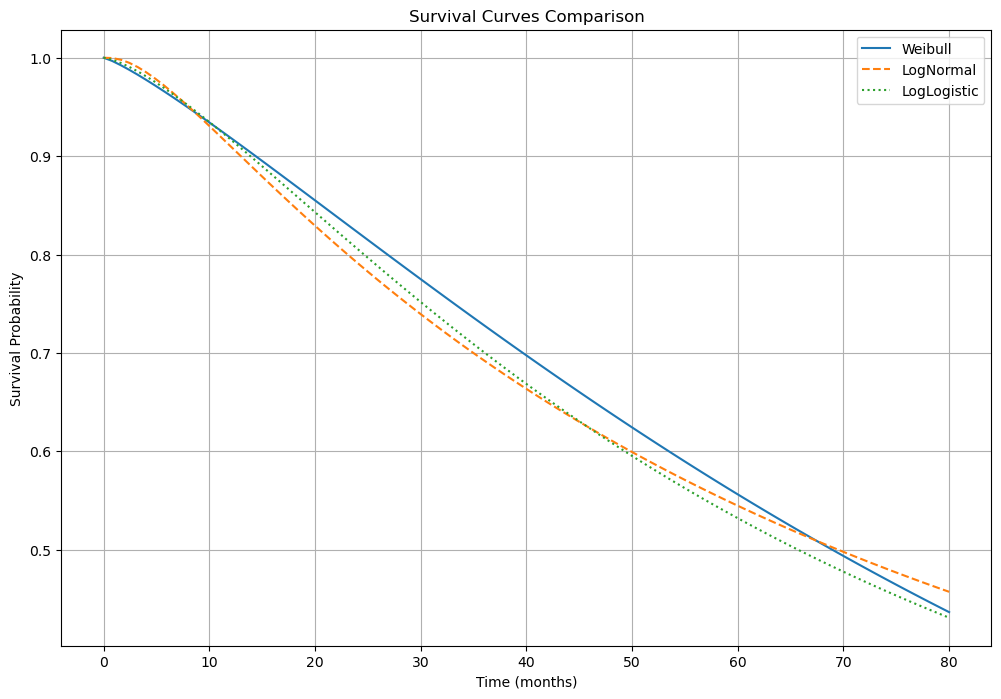

In [48]:
plt.figure(figsize=(12, 8))
plt.plot(timeline, weibull_aft.predict_survival_function(sample_data, times=timeline).values.flatten(), label='Weibull', linestyle='-')
plt.plot(timeline, lognormal_aft.predict_survival_function(sample_data, times=timeline).values.flatten(), label='LogNormal', linestyle='--')
plt.plot(timeline, loglogistic_aft.predict_survival_function(sample_data, times=timeline).values.flatten(), label='LogLogistic', linestyle=':')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.title('Survival Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()

### Feature Selection - Significant Features

In [77]:
lognormal_aft = LogNormalAFTFitter()
lognormal_aft.fit(data_encoded, duration_col='tenure', event_col='churn_event')
lognormal_summary = lognormal_aft.summary

In [79]:
alpha = 0.05
significant_features = lognormal_summary[lognormal_summary['p'] < alpha].index.tolist()

In [81]:
significant_cols = [feature[1] for feature in significant_features if isinstance(feature, tuple)]

In [85]:
final_features = ['tenure', 'churn_event'] + significant_cols
final_features = [col for col in final_features if col in data.columns]


In [91]:
final_data = pd.get_dummies(
    data[final_features],
    columns=[col for col in significant_cols if col in cat_vars],
    drop_first=True
)
final_data['churn_event'] = (data['churn'] == 'Yes').astype(int)

In [95]:
final_model = LogNormalAFTFitter()
final_model.fit(final_data, duration_col='tenure', event_col='churn_event')
final_model_summary = final_model.summary

## Customer Lifetime Value (CLV) Calculation

In [98]:
def calculate_clv(survival_prob, avg_monthly_revenue, discount_rate=0.01):
    time_periods = len(survival_prob)
    discount_factors = np.array([(1 / (1 + discount_rate)) ** t for t in range(time_periods)])
    clv = avg_monthly_revenue * np.sum(survival_prob * discount_factors)
    return clv

In [100]:
avg_monthly_revenue = 50
timeline = np.linspace(0, 36, 37)  

clv_values = []
for idx, row in data.iterrows():
    customer_data = pd.DataFrame([row])
    survival_prob = final_model.predict_survival_function(customer_data, times=timeline).values.flatten()
    clv = calculate_clv(survival_prob, avg_monthly_revenue)
    clv_values.append(clv)

data['CLV'] = clv_values

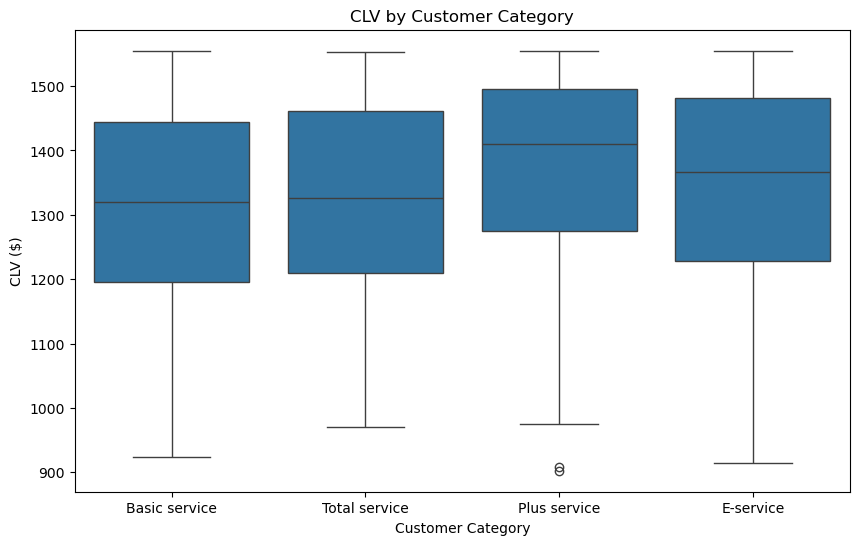

In [102]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='custcat', y='CLV', data=data)
plt.title('CLV by Customer Category')
plt.xlabel('Customer Category')
plt.ylabel('CLV ($)')
plt.show()

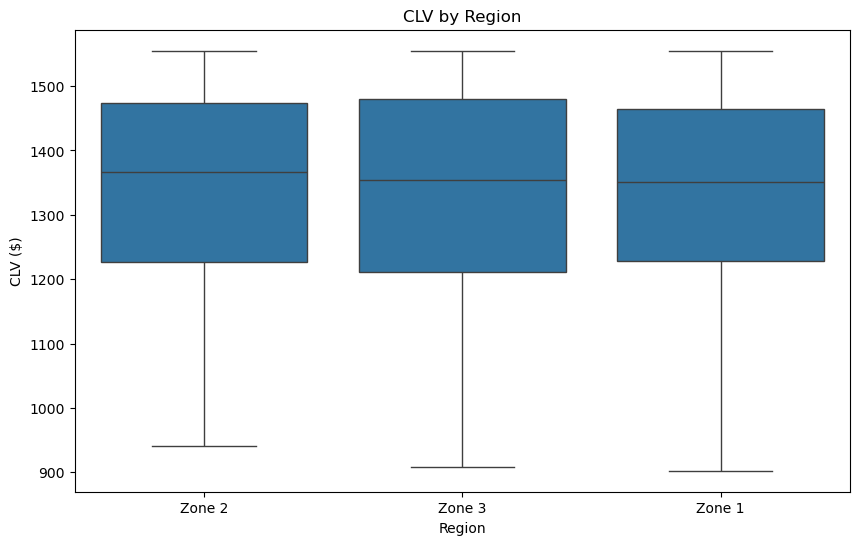

In [104]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='region', y='CLV', data=data)
plt.title('CLV by Region')
plt.xlabel('Region')
plt.ylabel('CLV ($)')
plt.show()

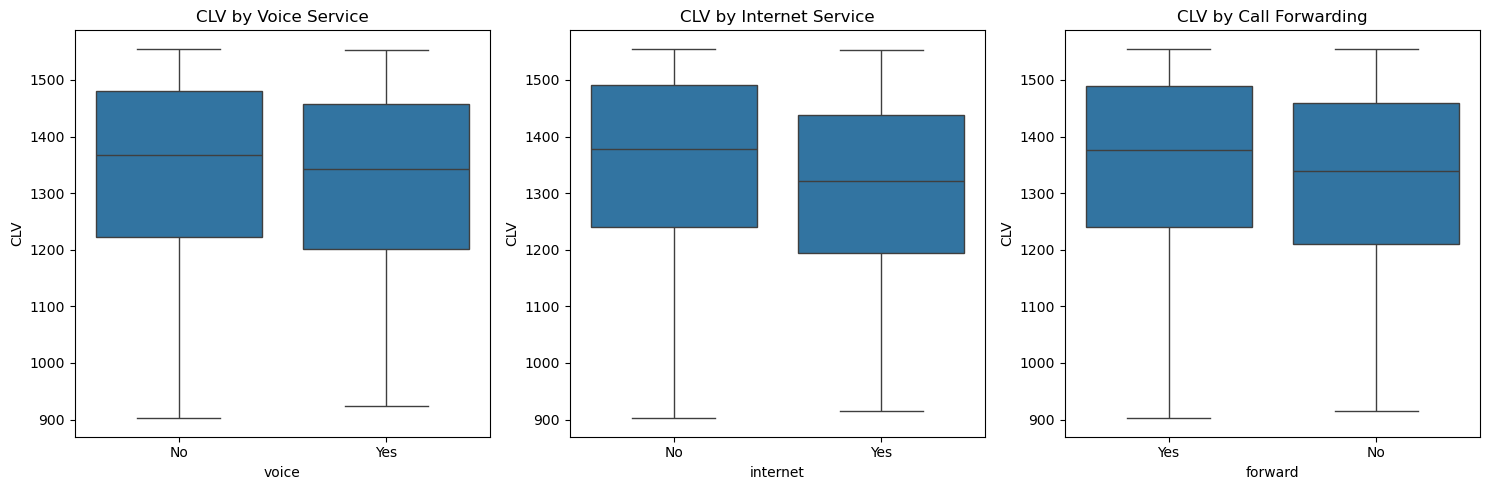

In [106]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='voice', y='CLV', data=data)
plt.title('CLV by Voice Service')
plt.subplot(1, 3, 2)
sns.boxplot(x='internet', y='CLV', data=data)
plt.title('CLV by Internet Service')
plt.subplot(1, 3, 3)
sns.boxplot(x='forward', y='CLV', data=data)
plt.title('CLV by Call Forwarding')
plt.tight_layout()
plt.show()

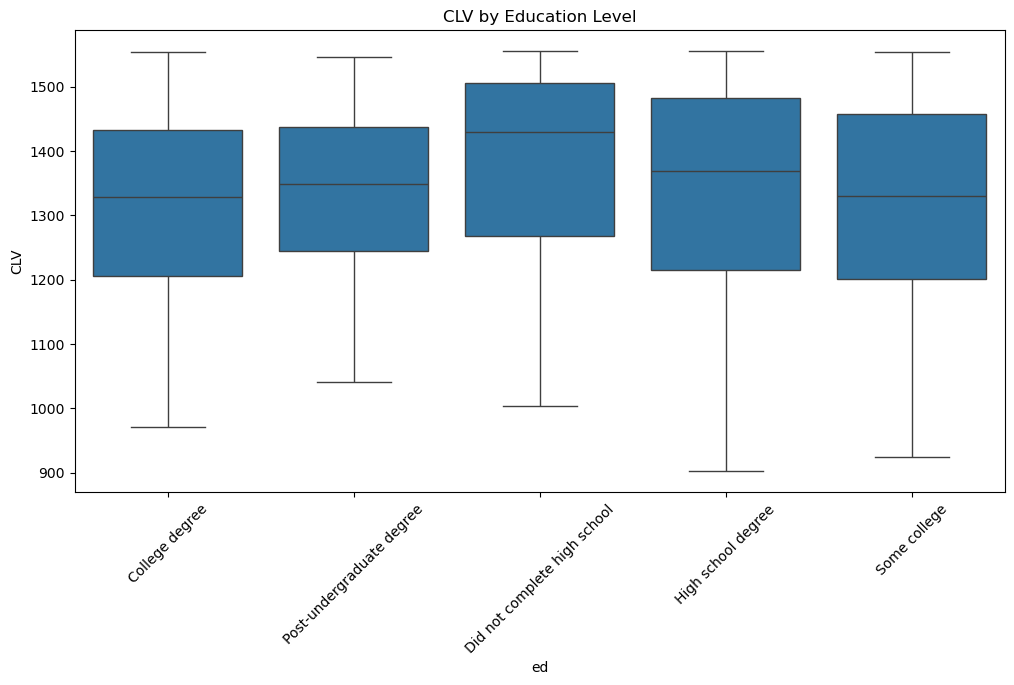

In [108]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='ed', y='CLV', data=data)
plt.title('CLV by Education Level')
plt.xticks(rotation=45)
plt.show()

## 12-month churn probability

In [113]:
timeline_12m = np.array([12])
churn_prob_12m = []
for idx, row in data.iterrows():
    customer_data = pd.DataFrame([row])
    survival_prob = final_model.predict_survival_function(customer_data, times=timeline_12m).values.flatten()[0]
    churn_prob = 1 - survival_prob
    churn_prob_12m.append(churn_prob)

data['churn_prob_12m'] = churn_prob_12m

In [115]:
high_value_threshold = data['CLV'].quantile(0.75)
high_risk_threshold = data['churn_prob_12m'].quantile(0.75)

data['high_value'] = data['CLV'] >= high_value_threshold
data['high_risk'] = data['churn_prob_12m'] >= high_risk_threshold
data['high_value_at_risk'] = data['high_value'] & data['high_risk']

In [117]:
if data['high_value_at_risk'].sum() > 0:
    annual_revenue_loss = data[data['high_value_at_risk']]['CLV'].sum() * data[data['high_value_at_risk']]['churn_prob_12m'].mean()
else:
    annual_revenue_loss = data[data['high_value']]['CLV'].sum() * data['churn_prob_12m'].mean()

retention_budget = annual_revenue_loss * 0.15

In [119]:
segment_analysis = data.groupby('custcat').agg({
    'CLV': 'mean',
    'churn_prob_12m': 'mean',
    'ID': 'count'
}).rename(columns={'ID': 'count'}).reset_index()

In [121]:
print(f"High-value customers: {data['high_value'].sum()}")
print(f"High-risk customers: {data['high_risk'].sum()}")
print(f"High-value at-risk customers: {data['high_value_at_risk'].sum()}")
print(f"Potential annual revenue loss: ${annual_revenue_loss:.2f}")
print(f"Suggested annual retention budget: ${retention_budget:.2f}")
print("\nCustomer Segment Analysis:")
print(segment_analysis)

High-value customers: 250
High-risk customers: 250
High-value at-risk customers: 0
Potential annual revenue loss: $41120.31
Suggested annual retention budget: $6168.05

Customer Segment Analysis:
         custcat          CLV  churn_prob_12m  count
0  Basic service  1306.281349        0.124585    266
1      E-service  1346.408312        0.102157    217
2   Plus service  1365.646041        0.092146    281
3  Total service  1322.531941        0.115372    236


High-value customers: 250
High-risk customers: 250
High-value at-risk customers: 0
Potential annual revenue loss: $41120.31
Suggested annual retention budget: $6168.05


In [135]:
!pip freeze > requirements.txt
